## Scratchpad

### For implementing model discussed in Geisler, 1984

In [1]:
import numpy as np
import helper_fcns as hf
from scipy.stats import poisson
import autoreload
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import pandas as pd
import seaborn as sns
%matplotlib inline

#### Checking figure 1

In [9]:
x = np.linspace(-4.25, 4.25, 101)
lsf = hf.linespread_function(x)

The following function does not have the same amplitude as the one shown in the figure. However, I'm pretty sure this is because the one in the figure is just re-scaled so that its maximum value is 1 (hence the label of relative amplitude). Based on the figure legend ("the actual point-spread function was obtained from the smooth curve by assuming that the eye is isotropic and by normlizing the total volume under the function to 1.0"), I believe the following is correct for the calculations.

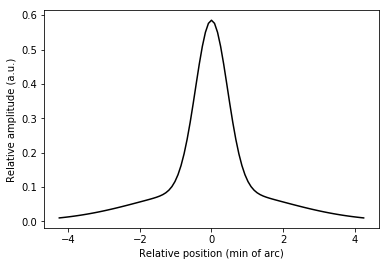

In [11]:
plt.plot(x, lsf, 'k')
#plt.ylim(0, 1.10)
plt.xlabel('Relative position (min of arc)')
_=plt.ylabel('Relative amplitude (a.u.)')

#### Point-spread function

Note: In the text, we assume the optics are isotropic, as in same everywhere. Thus, we can assume that the linespread function "generalizes" radially, and thus we use a 2D, radially symmetric gaussian to go from line-spread to point-spread

In [4]:
psf = hf.pointspread_function(x, x)

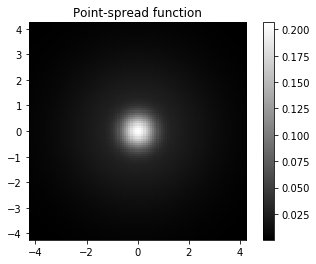

In [5]:
plt.imshow(psf, extent=[-4.25, 4.25, -4.25, 4.25], cmap='gray')
plt.title('Point-spread function')
plt.colorbar()

#### Plotting a Poisson distribution

The number of photoreceptors absorbed is described by the poisson density, based on some mean number of quanta absorbed (see the next section)

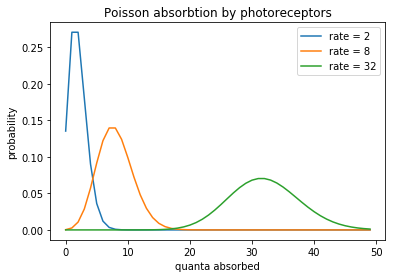

In [6]:
n_absorbed = np.arange(0, 50) # poisson process must have non-negative integer evaluations only!
labels = []
# rate is the mean number of quanta absorbed
for rate in [2, 8, 32]:
    plt.plot(n_absorbed, poisson.pmf(n_absorbed, rate))
    labels.append("rate = %s" % rate)
plt.legend(labels)
plt.xlabel('quanta absorbed')
plt.ylabel('probability')
_=plt.title('Poisson absorbtion by photoreceptors')

#### Creating the hexagonal photoreceptor lattice

Since this is a hexagonal lattice, the center-to-center distances of any three neighboring cones form an equilateral triangle. We also know that this distance (equivalently, the diameter of the receptors) is .6 arcminutes.

Therefore (using some basic trigonometry: $\tan(\frac{\pi}{3})=\sqrt{3}$), if the center of one receptor is at the point $(0,0)$, then the neighboring receptors have centers at: $(.6, 0), (.3, .3\sqrt{3}), (-.3, .3\sqrt{3}), (-.6, 0), (-.3, -.3\sqrt{3}), (.3, -.3\sqrt{3})$

In [13]:
lattice, xmin, ymin, x, y = hf.construct_photoreceptor_lattice(13.)

When the lattice gets big, it needs to be plotted on a larger and larger figsize, otherwise some of the points won't get plotted. The following `np.sum` confirms that the correct number of centers were added (though it does nothing to determine if they were correctly placed)

In [14]:
np.sum(lattice)

169.0

If we drew circles and the triangle on this, we could make this look like figure 2

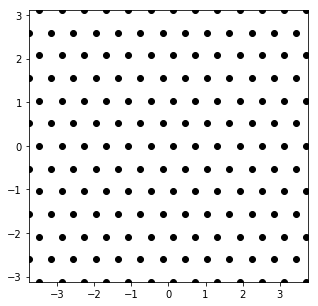

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
hf.visualize_receptor_lattice(lattice, x, y, cmap='gray')

#### Calculating mean absorbtion

In [15]:
# for creating luminance signal - just a point source
lum = 3; # in cd/m2

col_labels = ['receptor area', 'stimulus duration', 'pupil area', 'ocular media transittance', 'photoreceptor efficiency', 'label', 'mean photons absorbed by center photoreceptor']
values = [[.28, .2, 3.1416, .68, .5, 'default'],
          [.28, .5, 3.1416, .68, .5, 'more time'],
          [.28, .2, 3.1416, .68, .9, 'more efficient'],
          [.2, .2, 3.1416, .68, .5, 'smaller receptors']]
df = []

for i, (a, d, s, t, e, label) in enumerate(values):
    retinal_image = hf.retinal_image(lum, psf)
    photoreceptor_absorptions = hf.mean_photons_absorbed(retinal_image, lattice, a, d, s, t, e)
    df.append(pd.DataFrame(dict((col, val) for val, col in zip([a, d, s, t, e, label, photoreceptor_absorptions[hf.get_middle(photoreceptor_absorptions)]], col_labels)), index=[i]))

df = pd.concat(df)
df['percent default'] = 100 * df['mean photons absorbed by center photoreceptor'] / df[df.label=='default']['mean photons absorbed by center photoreceptor'].values

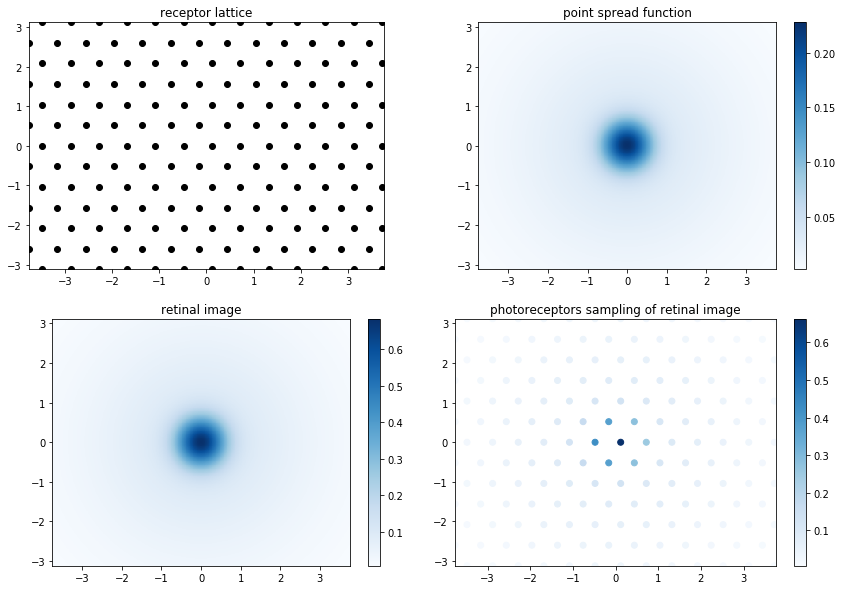

In [29]:
data = [lattice, psf, retinal_image, retinal_image * lattice]
titles = ['receptor lattice', 'point spread function', 'retinal image', 'photoreceptors sampling of retinal image']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, (im, title, ax) in enumerate(zip(data, titles, axes.flatten())):
    if i in [1, 2]:
        plotted = ax.imshow(im, extent=[-xmin, xmin, -ymin, ymin], cmap='Blues', aspect='equal')
    elif i in [0, 3]:
        plotted = hf.visualize_receptor_lattice(im, x, y, ax=ax, cmap='Blues')
    if i in [1,2,3]:
        plt.colorbar(plotted, ax=ax, fraction=.046)
    ax.set_title(title)

The following aren't surprising: the mean absorbtion is linear in all parameters a, d, s, t, e 

In [17]:
df

,label,mean photons absorbed by center photoreceptor,ocular media transittance,photoreceptor efficiency,pupil area,receptor area,stimulus duration,percent default
0,default,13.780733,0.68,0.5,3.1416,0.28,0.2,100.000000
1,more time,34.451833,0.68,0.5,3.1416,0.28,0.5,250.000000
2,more efficient,24.805320,0.68,0.9,3.1416,0.28,0.2,180.000000
3,smaller receptors,9.843381,0.68,0.5,3.1416,0.20,0.2,71.428571


Now, we can compare distributions: how discriminable will these be?

I think the first plot here is correct, because the units are in actual quanta of photons absorbed, rather than in what percentage that is of the original.

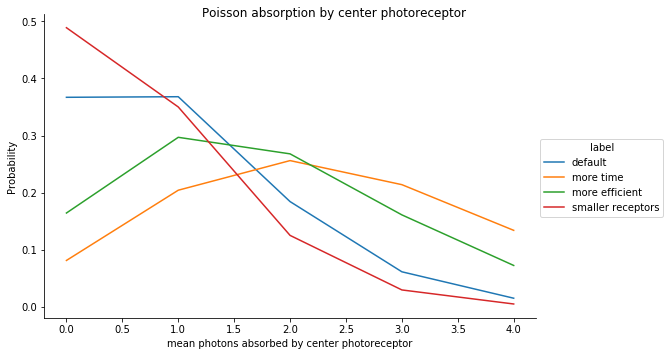

In [17]:
n_absorbed = np.arange(0, 5)
def absorption_plot(mean_absorbed, **kwargs):
    plt.plot(n_absorbed, poisson.pmf(n_absorbed, mean_absorbed), **kwargs)
g = sns.FacetGrid(df, hue='label', size=5, aspect=1.5)
g.map(absorption_plot, 'mean photons absorbed by center photoreceptor')
g.fig.suptitle('Poisson absorption by center photoreceptor')
g.set_ylabels('Probability')
g.add_legend()

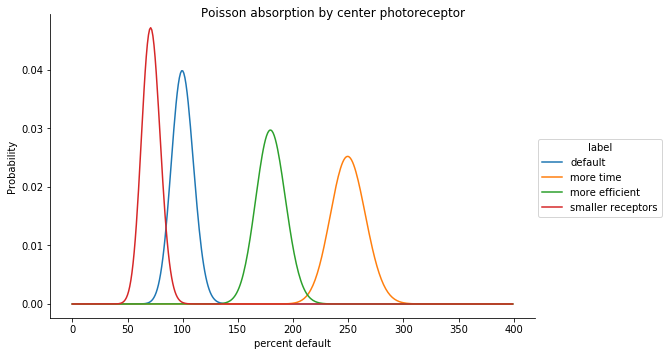

In [18]:
n_absorbed = np.arange(0, 400)
def absorption_plot(mean_absorbed, **kwargs):
    plt.plot(n_absorbed, poisson.pmf(n_absorbed, mean_absorbed), **kwargs)
g = sns.FacetGrid(df, hue='label', size=5, aspect=1.5)
g.map(absorption_plot, 'percent default')
g.fig.suptitle('Poisson absorption by center photoreceptor')
g.set_ylabels('Probability')
g.add_legend()

#### Checking the convolution calculation

Let's try something other than a point-source for light

In [20]:
# for creating luminance signal - gaussian
lum = 3; # in cd/m2
lum_sigma = .5
lum_signal = lum * hf.gauss_2d(x, y, 1, lum_sigma)
# absolute values likely not right...

retinal_image = hf.retinal_image(lum_signal, psf)

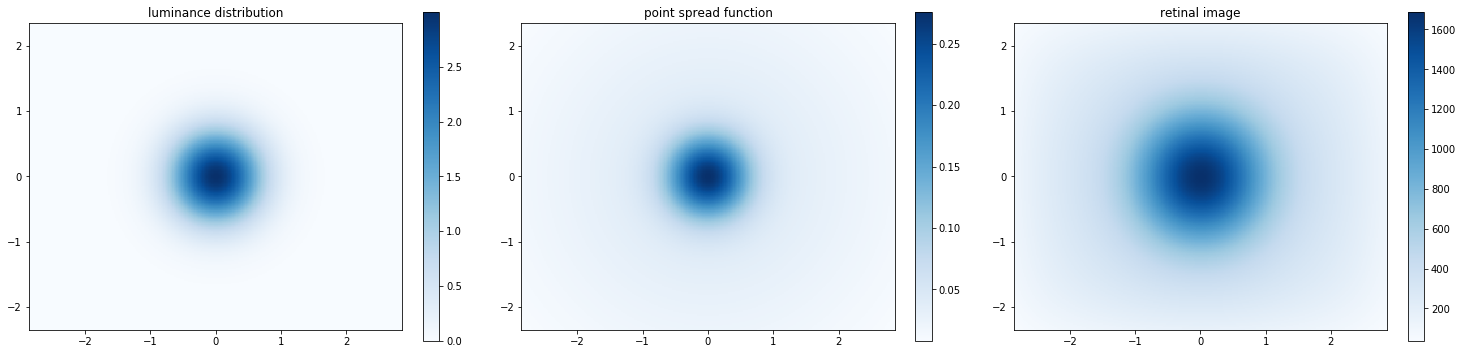

In [22]:
f, axes = plt.subplots(1, 3, figsize=(25, 10))

for im, title, ax in zip([lum_signal, psf, retinal_image], ['luminance distribution', 'point spread function', 'retinal image'], axes.flatten()):
    plotted = ax.imshow(im, extent=[-xmin, xmin, -ymin, ymin], cmap='Blues')
    plt.colorbar(plotted, ax=ax, fraction=.04)
    ax.set_title(title)

In [24]:
# for creating luminance signal - edge
lum_signal = np.ones((len(y), len(x)));
lum_signal[:, 0:hf.get_middle(x)] = 0

retinal_image = hf.retinal_image(lum_signal, psf)

But this isn't ideal -- convolutions make edges weird so we generally want to make sure there's no signal at the edge of the luminance image.

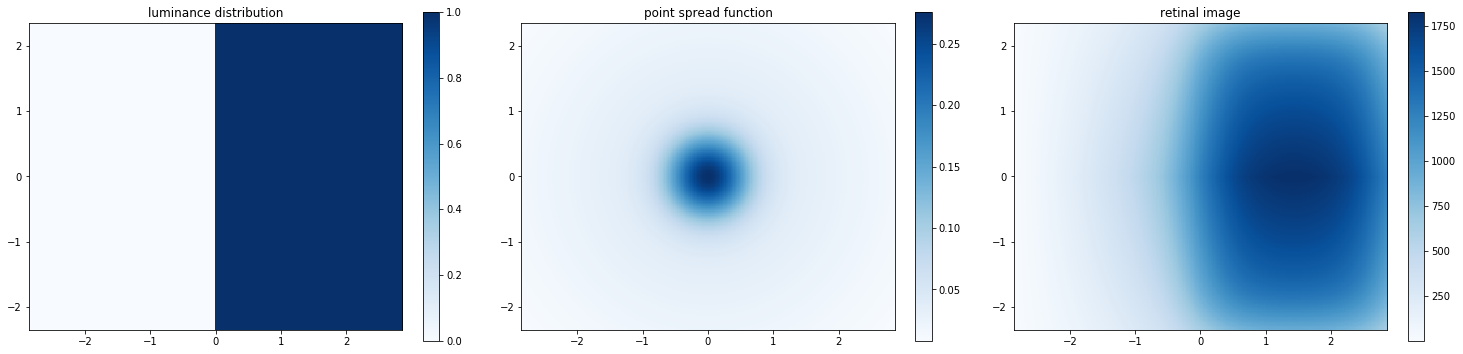

In [25]:
f, axes = plt.subplots(1, 3, figsize=(25, 10))

for im, title, ax in zip([lum_signal, psf, retinal_image], ['luminance distribution', 'point spread function', 'retinal image'], axes.flatten()):
    plotted = ax.imshow(im, extent=[-xmin, xmin, -ymin, ymin], cmap='Blues')
    plt.colorbar(plotted, ax=ax, fraction=.04)
    ax.set_title(title)

#### Generate figure 4

The numbers here don't line up. See the following graph.

Here, we're try to recreate Figure 4, finding the relationship between $N$ and $\Delta N$, where $N$ is the "mean number of quanta per stimulus", or $\sum_i\frac{\beta_i+\alpha_i}{2}$ and $\Delta N$ is the "average difference in number of effectively absorbed quanta from stimuli $\alpha$ and $\beta$ or $\sum_i\beta_i-\alpha_i$ when $d'=1.36$, at threshold. The line for our solution is consistently above Geisler's and it's not clear whether ours is correct.

I think it is, because our lies on the line given by $\delta N=1.36\sqrt{N}$, which Geisler says is the correct solution. However, I'm not sure what the base of the logarithm used in the plot is. Presumably, it's the natural logarithm, which is shown below, but the position of our line (and the $\delta N=1.36\sqrt{N}$ line) shifts around if a different base is used. But no reasonable value (2, 10, $e$) makes them line up, so I don't think that's the issue.

/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py:253: RuntimeWarning: invalid value encountered in true_divide
  log_ratio = np.log(beta / alpha)
/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py:323: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(x), np.log(y), 'k--', label='$\Delta N = 1.36\sqrt{N}$')


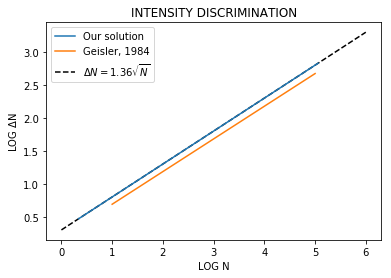

In [11]:
solts = hf.figure4([.2, .5, .75, 1, 2, 3, 4, 5, 6, 10, 15, 20, 50], 1.36)

Weirdly, our two results lie basically on top of Geisler's if we set $d'=\sqrt{1.36}$, and I'm not sure why that would be.

/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py:210: RuntimeWarning: invalid value encountered in true_divide
  log_ratio = np.log(beta / alpha)
/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py:280: RuntimeWarning: divide by zero encountered in log
  plt.legend(np.log(x), np.log(y), label='$\delta N = 1.36\sqrt{N}$')


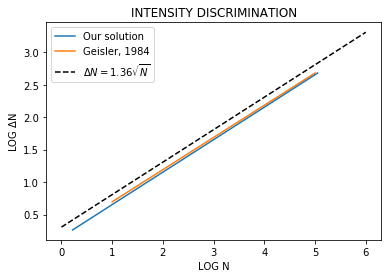

In [86]:
solts = hf.figure4([.2, .5, .75, 1, 2, 3, 4, 5, 6, 10, 15, 20, 50], np.sqrt(1.36))

#### Resolution task

In [116]:
autoreload.reload(hf)

<module 'helper_fcns' from '/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py'>

We're having an issue: when either alpha or beta is 0, log messes up (returning either infinity or nan). currently we're casting the log ratio to 0, but that seems wrong. how do?

In [7]:
ret_a, ret_b, lat, x, y = hf.resolution_task(.11)
ret_a_abs = hf.retina_photons_absorbed(ret_a, lat)
ret_b_abs = hf.retina_photons_absorbed(ret_b, lat)
a = hf.mean_photons_absorbed(ret_a, lat)
b = hf.mean_photons_absorbed(ret_b, lat)

/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py:15: UserWarning: x has no middle index, returning the floor instead
  warnings.warn("x has no middle index, returning the floor instead")


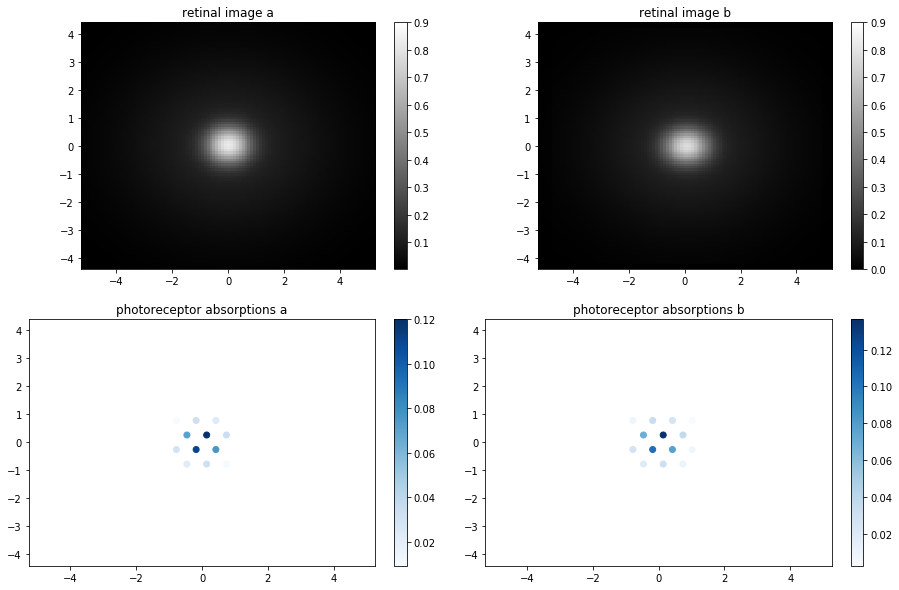

In [8]:
x_minutes = x.max()
y_minutes = y.max()
fig, axes = plt.subplots(2, 2, figsize=(15, 10), squeeze=True)
for ax, im, title in zip(axes.flatten(), [ret_a, ret_b, ret_a_abs, ret_b_abs], ['retinal image a', 'retinal image b', 'photoreceptor absorptions a', 'photoreceptor absorptions b']):
    if 'retinal' in title:
        plotted = ax.imshow(im, cmap='gray', extent=[-x_minutes, x_minutes, -y_minutes,y_minutes], vmax=.9)
    else:
        plotted = hf.visualize_receptor_lattice(im, x, y, ax=ax, cmap='Blues')
    plt.colorbar(plotted, ax=ax, fraction=.04)
    ax.set_title(title)
fig.savefig('absorptions.svg')

Let's figure out where those places are. I need to get a legend working, but right now the blue dots are in both a and b, the green dots are only in b, and any red dots are only in a (there aren't any of these right now)

In [9]:
lat[np.where((ret_b_abs!=0)&(ret_a_abs==0))] = 2
lat[np.where((ret_b_abs==0)&(ret_a_abs!=0))] = -1
lat[np.where((ret_b_abs==0)&(ret_a_abs==0))] = 0

No handles with labels found to put in legend.


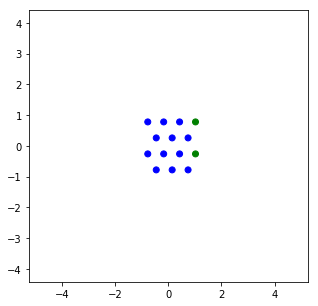

In [10]:
plt.figure(figsize=(5,5))
plotted = hf.visualize_receptor_lattice(lat, x, y, mode='categorical')
# plt.colorbar(plotted, fraction=.04)
ax.legend()